# Apache Arrow shared between Python and R with rpy2

The Python package shown here is available at:
https://github.com/rpy2/rpy2-arrow

**Warning:** This currently requires a nightly build of the R package `arrow`. It
can be installed with the following command in R:

```r
install.packages("arrow", repos = "https://arrow-r-nightly.s3.amazonaws.com")
```

In [1]:
import pyarrow
import pyarrow.dataset as ds
import rpy2_arrow.pyarrow_rarrow as pyra

Our dataset in the NYC taxi one made available to download in the Parquet format by Ursa Labs.

In [2]:
DATA_PATH = 'nyc-taxi'

## Setup: Get a dataset

Most will not have that data already available locally in directories. We use a Python
translation of the code as https://ursalabs.org/arrow-r-nightly/articles/dataset.html
to fetch the data.

In [3]:
# This allows download an incomplete dataset
# in the interest of time. Set it to None or -1
# to download the complete dataset.
MAX_NMONTHS = 5

import os
import urllib.parse
import urllib.request
import shutil

BUCKET = 'https://ursa-labs-taxi-data.s3.us-east-2.amazonaws.com'
paths = []
print('     |            |')
for year in range(2009, 2020):
    if len(paths) == MAX_NMONTHS:
        print()
        break
    print(f'{year} ', end='', flush=True)
    if year == 2019:
        # We only have through June 2019 there
        months = range(1, 7)
    else:
        months = range(1, 13)
    for month in months:
        if len(paths) == MAX_NMONTHS:
            print()
            break
        month_str = f'{month:02d}'
        year_str = str(year)
        url = urllib.parse.urljoin(BUCKET, '/'.join((year_str, month_str, 'data.parquet')))
        filename = os.path.join(DATA_PATH, year_str, month_str, 'data.parquet')
        if os.path.exists(filename):
            print('s', end='', flush=True)
            paths.append(filename)
            continue
        print('D', end='', flush=True)
        os.makedirs(os.path.join(DATA_PATH, year_str, month_str))
        with urllib.request.urlopen(url) as response, open(filename, 'wb') as output_file:
            shutil.copyfileobj(response, output_file)
        paths.append(filename)
    print()


     |            |
2009 sssss




## We are ready, let's load a dataset

The dataset is read using `pyarrow.dataset`:

In [4]:
dataset = ds.dataset(paths, format='parquet')
dataset

The following line reads the dataset into an Arrow table. Depending on the size
of the data this may require a lot of memory so we apply a filter (check the relevant documentation
for more details: https://arrow.apache.org/docs/python/dataset.html).

In [5]:
tbl = dataset.to_table(filter=ds.field('tip_amount') > 10)
tbl.shape

(120971, 18)

To make our Arrow table read with Python accessible to R by simply passing the R pointer we can do:

In [6]:
r_tbl = pyra.converter.py2rpy(tbl)

The table can then used in R, allowing to take advantage of individual strengths in a data science team
(some prefer writing R code) or libraries in R for which there is arguably no matching equivalent in Python.

In [7]:
%load_ext rpy2.ipython

In [8]:
%%R -i r_tbl
print(class(r_tbl))

[1] "Table"       "ArrowObject" "R6"         


In [10]:
%%R -i r_tbl

library(dplyr, warn.conflicts = FALSE)
r_tbl %>%
  mutate(tip_group = round(tip_amount / 5) * 5) %>%
  count(tip_group)

# A tibble: 19 x 2
   tip_group     n
       <dbl> <int>
 1        10 66301
 2        15 33250
 3        20 10285
 4        25  3596
 5        30  2328
 6        35  1298
 7        40   802
 8        45   540
 9        50   748
10        55   551
11        60   381
12        65   181
13        70   145
14        75   132
15        80   135
16        85    69
17        90    94
18        95    55
19       100    80


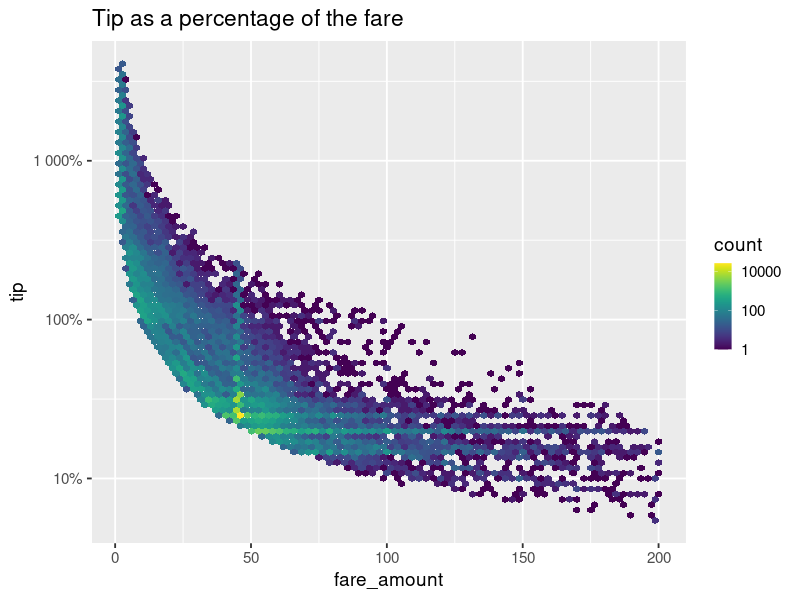

In [22]:
%%R -w 800 -h 600 --type cairo-png
library(ggplot2, warn.conflicts = FALSE)
library(viridis)
options(bitmapType="cairo")
X11.options(antialias = "subpixel")
p <- ggplot(r_tbl %>% collect()) +
  geom_hex(aes(x = fare_amount, y = tip_amount/fare_amount),
           bins = 75) +
  scale_fill_viridis(trans="log10") +
  scale_y_continuous("tip", labels = scales::percent, trans="log10") +
  ggtitle("Tip as a percentage of the fare") + 
  theme_gray(base_size=19)
print(p)